# Photometric Deflectometry
Following hardware setups are required prior to capture:
- Camera
- Screen Projection (Monitor)

Calibration Sessions:
- Camera Intrinsic Calibration
- Geometric Calibration (Location of Monitor w.r.t. Camera)

## 0. Import Libraries

In [1]:
from hardware.camera import *
from hardware.projection import *
from hardware.pattern import *
from reconstruction.gradient_reconstruction import *
from calibration.intrinsic_calibration import *
from calibration.geometric_calibration import *

import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets

from screeninfo import get_monitors

%load_ext autoreload
%autoreload 2

## 1. Camera Setup

In [ ]:
cam = Flir() # Flir camera init
cam.setExposure(30000) # set exposure time
cam.setGain(0) # set gain

# Flir camera caputer images
# capture one image
cam.getImage(name='test1') # This image is stored as "CapturedImages/test.png"
# capture images for calibration
# calibrationName can be 'Intrinsic', 'Geometric' etc.
# images are stored in CalibrationImages/calibrationName file
# cam.getImage(calibration = True, calibrationName = 'Intrinsic')
# cam.getImage(calibration = True, calibrationName = 'Geometric')

# capture sequence images with sin pattern in two directions
# the projector show patterns and camera capture images of the object
# cam.captureSeqImages() # images are stored in "CapturedImages/sequenceImages" file

## 2. Screen Projection (Monitor)

In [ ]:
monitor_list = get_monitors() # get monitor list (offset values: x, y ; screen resolution: width, height)
projection = Screen(monitor_list=monitor_list, monitor_index=1)
projection.setPattern(GradientPattern(projection.resolution))

## 3. Example Capture Session

In [ ]:
# Number of patterns to display in each direction e.g npg=2 -> 2 x X Pattern & 2 x Y Pattern
nph = 2
# Set up image processing/reconstruction
image_processing = GradientReconstruction(n=nph)

# Set up your capture session
cap = GradientCapture(cam, projection, image_processing, n=nph)
#cap = DeflectometryCapture.DeflectometryCapture(cam, projection, image_processing, nph=nph)

# Capture images and adjust parts of RGB to display
print("Capturing...")
cap.capture(red=1.0, blue=1.0, green=1.0)
cam.quit_and_close()

## 4. Intrinsic Calibration
- dict_aruco: dictionary (eg. DICT_4X4_250 means the dictionary is composed of 250 markers and a marker size of 4x4 bits.)
- sqWidth: number of squares in one row (checker + aruco)
- sqHeight: number of squares in one column (checker + aruco)
- checkerSquareSize: measured checker size （side length） in meter
- markerSquareSize: measured aruco marker size （side length） in meter

In [2]:
# initialize intrinsic calibration
intrinsic_calib = IntrinsicCalibration(dict_aruco=cv2.aruco.DICT_4X4_250, 
                                       sqWidth=10, sqHeight=7, checkerSquareSize=0.025, markerSquareSize=0.01926)

intrinsic_calib.calibration(imgFolder="./data/capture_intrinsic/", imgPattern="*.tif") # intrinsic calibration
intrinsic_calib.undistort(imgFolder="./data/capture_geometric/", imgPattern="*.tif") # undistort other imgs based on intrinsic calibration

  0%|          | 0/1 [00:00<?, ?it/s]

NumImg: 14
Rep Error: 0.29996000463900824
Camera Matrix: [[2.07317730e+03 0.00000000e+00 9.92726083e+02]
 [0.00000000e+00 2.06473460e+03 7.17935008e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


## 5. Geometric Calibration

reProjAruco


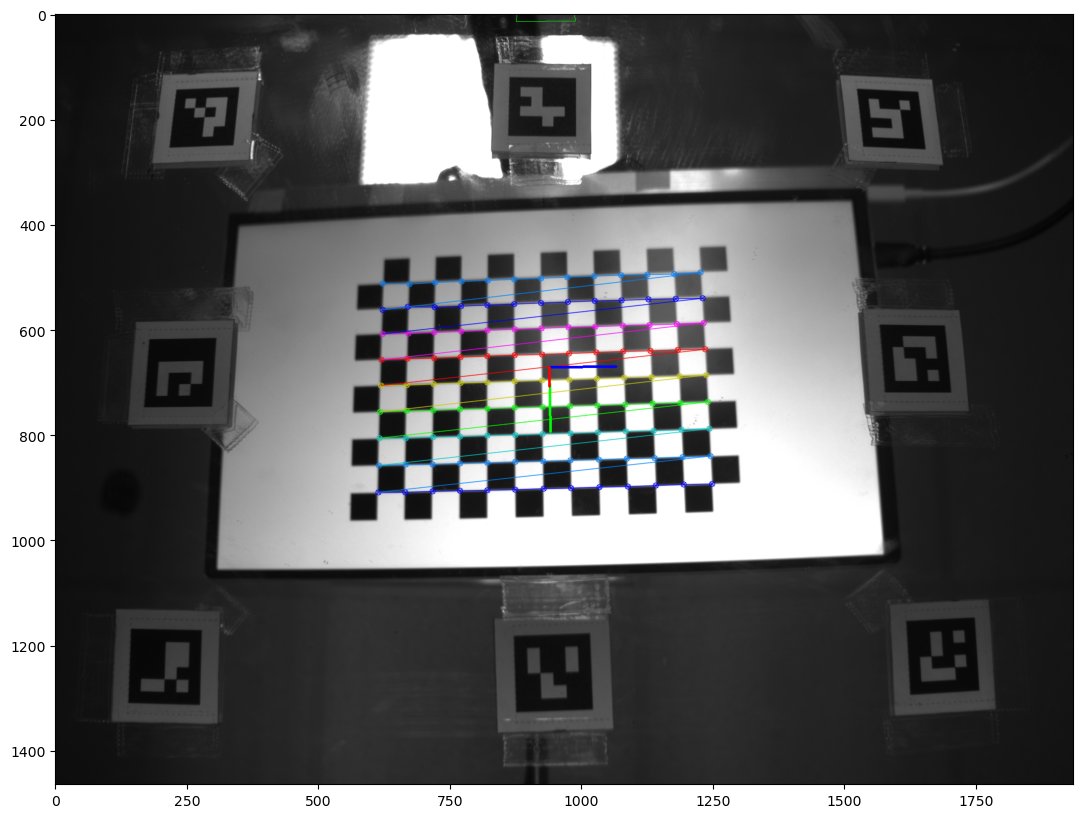

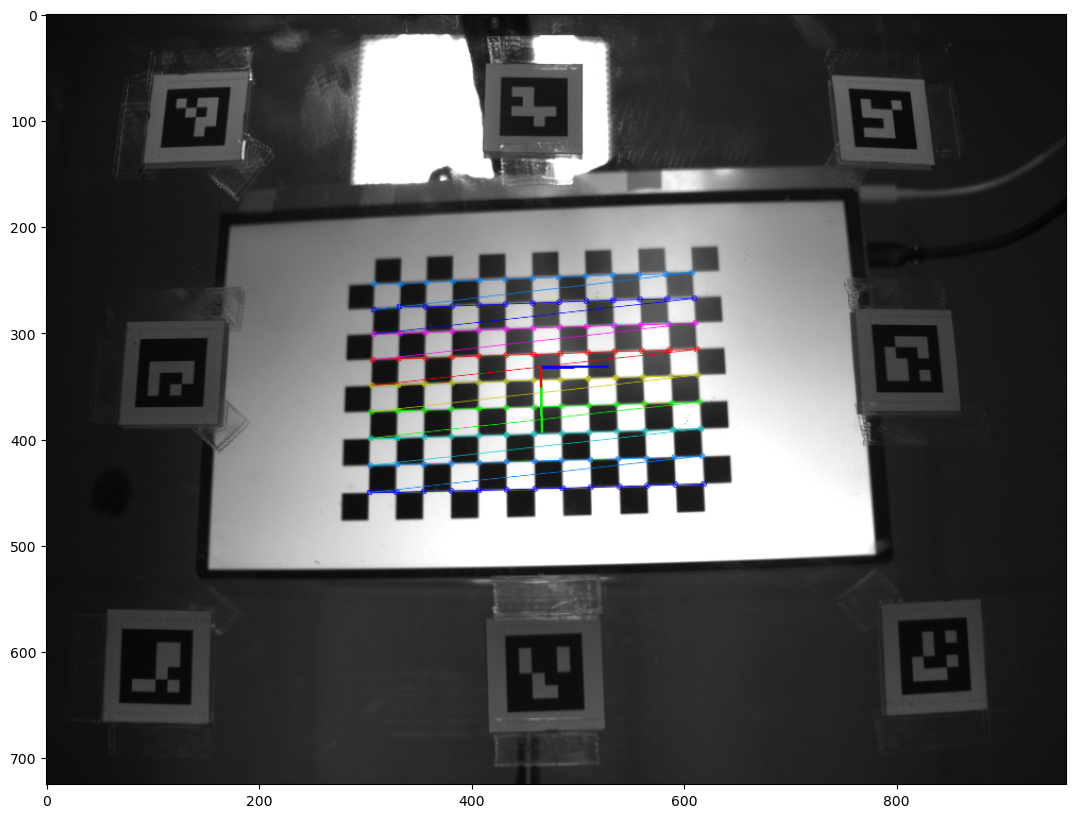

[[-0.11599336]
 [-0.03508759]
 [ 3.49904991]]
rC2S: [[ 0.99480796  0.01080906  0.10119434]
 [-0.02254449 -0.94623305  0.32269918]
 [-0.0992415   0.32330509  0.94107648]]
tC2S: [ 0.20991045 -0.923523    2.7576193 ]


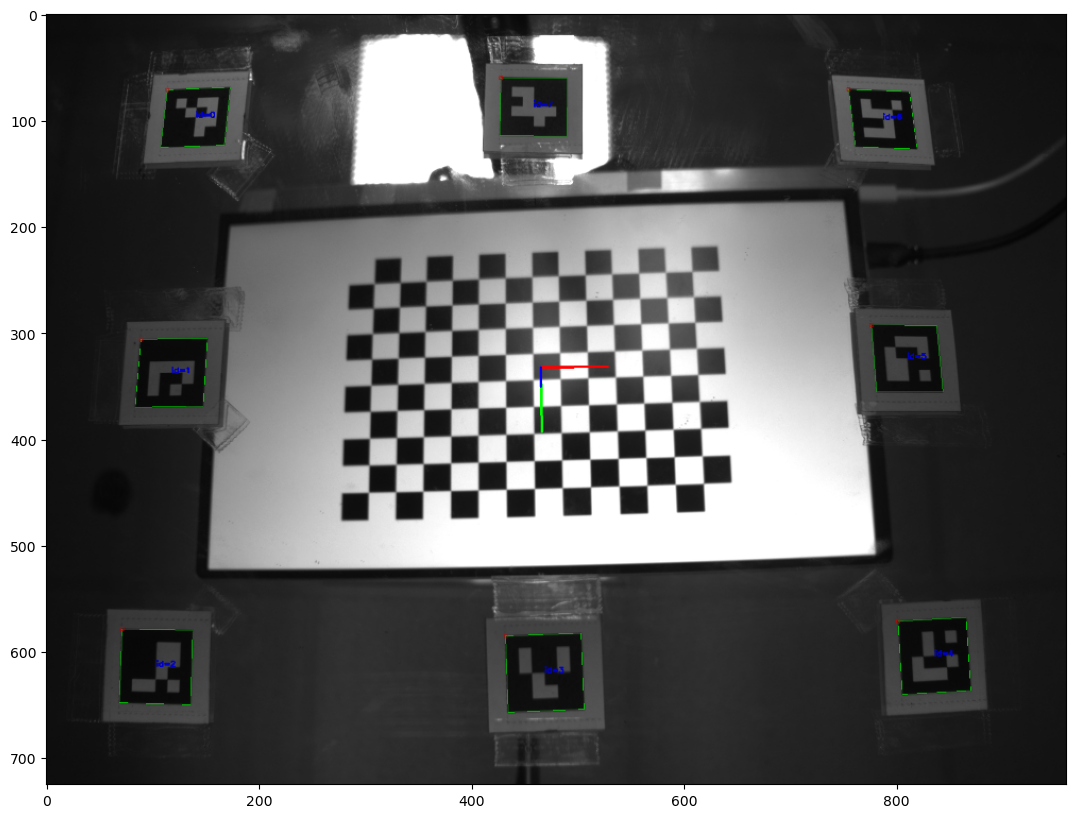

cam z axis in world coor is  [ 0.03096184 -0.28487774  0.95806369]
cam zero point in world coor is  [-0.00171935  0.09980308 -0.30933704]
display z axis in world coor is  [-0.07381577  0.03976509  0.99647878]
display zero in world coor is  [-0.0089035  -0.93294397 -3.0360206 ]


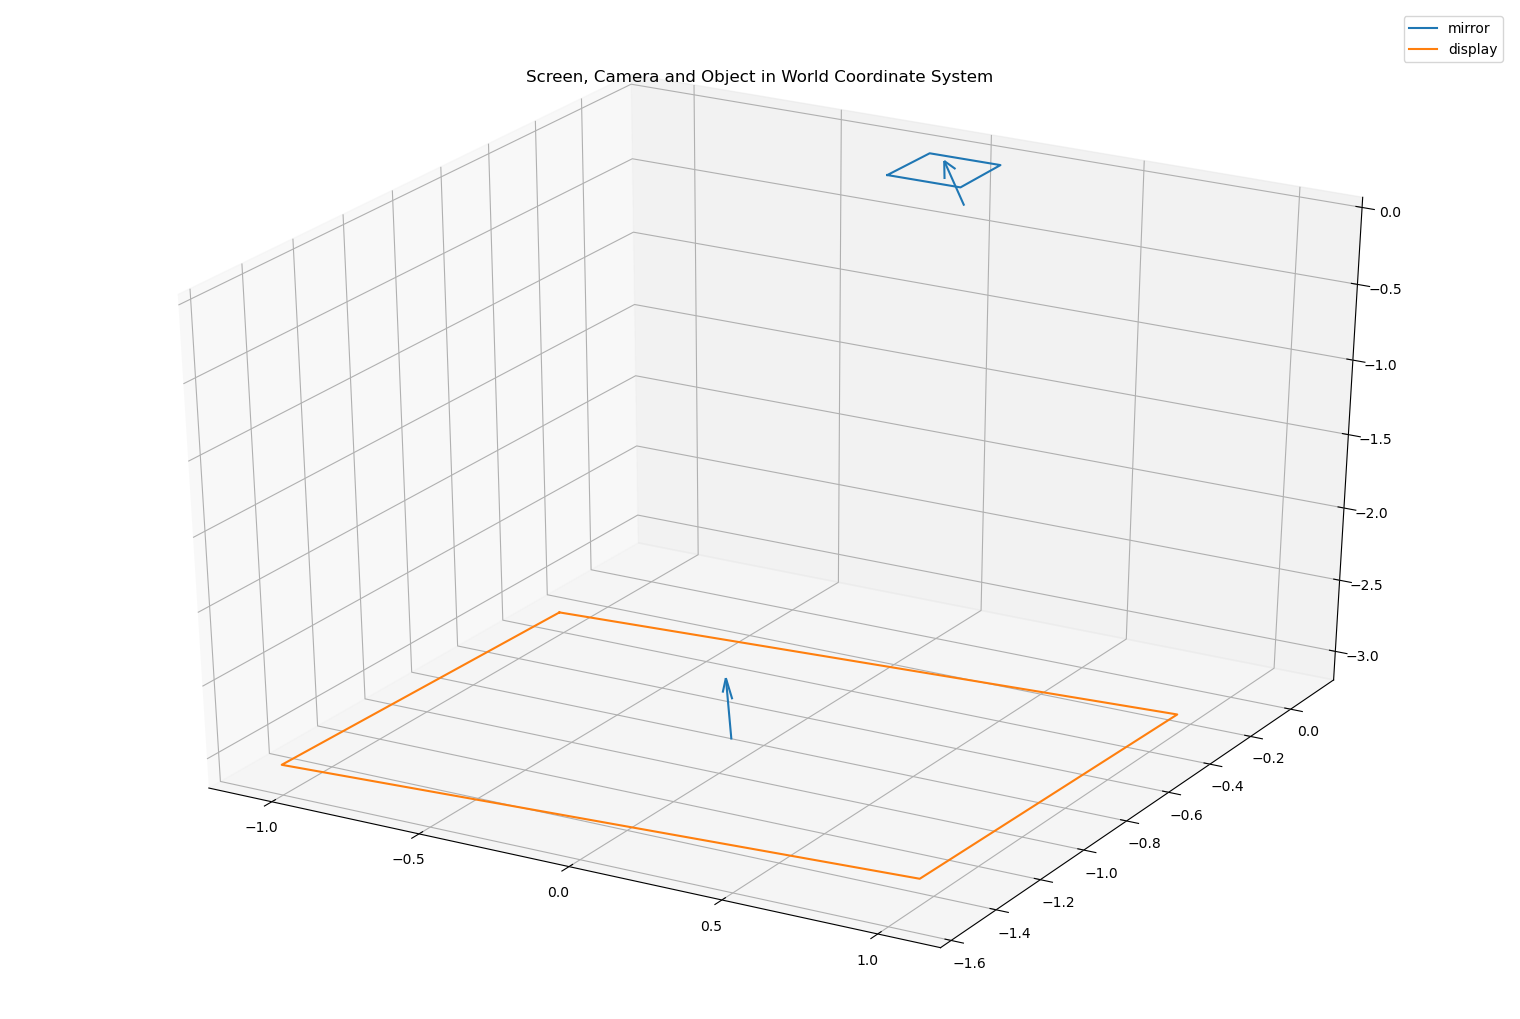

In [3]:
# half length and width of mirror, -0.005 represents that the outer corner of marker is 5mm blank edge, which needs to be distracted.
half_length = 0.245 / 2 # 24.5cm
half_height = 0.20 / 2 # 20cm
marker_size = 0.02 # 20.45mm

# display scale factor, which is the ratio of single checker square length between metric and pixel unit.
# for example, if the length of a checke square on display in 65mm, and it takes 60 pixel in screen, so the ratio is 0.065/60.
# displayScaleFactor = 0.15/ (23*15) #0.0011
# 140 mm
# displayScaleFactor = 0.115/(80 * 8)
displayScaleFactor = 0.0011 # TODO: change later

geoCalibImgFile = './data/capture_geometric/checker.tif' # location of raw distorted image
# location of undistorted image
geoCalibImgUndistortFile = './data/capture_geometric/undistort/checker.tif'
displayintersect, camdisintersect, rc2s, tc2s = geoCalib(geoCalibImgFile, geoCalibImgUndistortFile, half_length, half_height, marker_size, 
                                                            intrinsic_calib.cameraMatrix, intrinsic_calib.distortionCoeff, intrinsic_calib.ret, 
                                                            displayScaleFactor)
# result images are saved in geoCalibResults file

<Figure size 1500x1000 with 0 Axes>

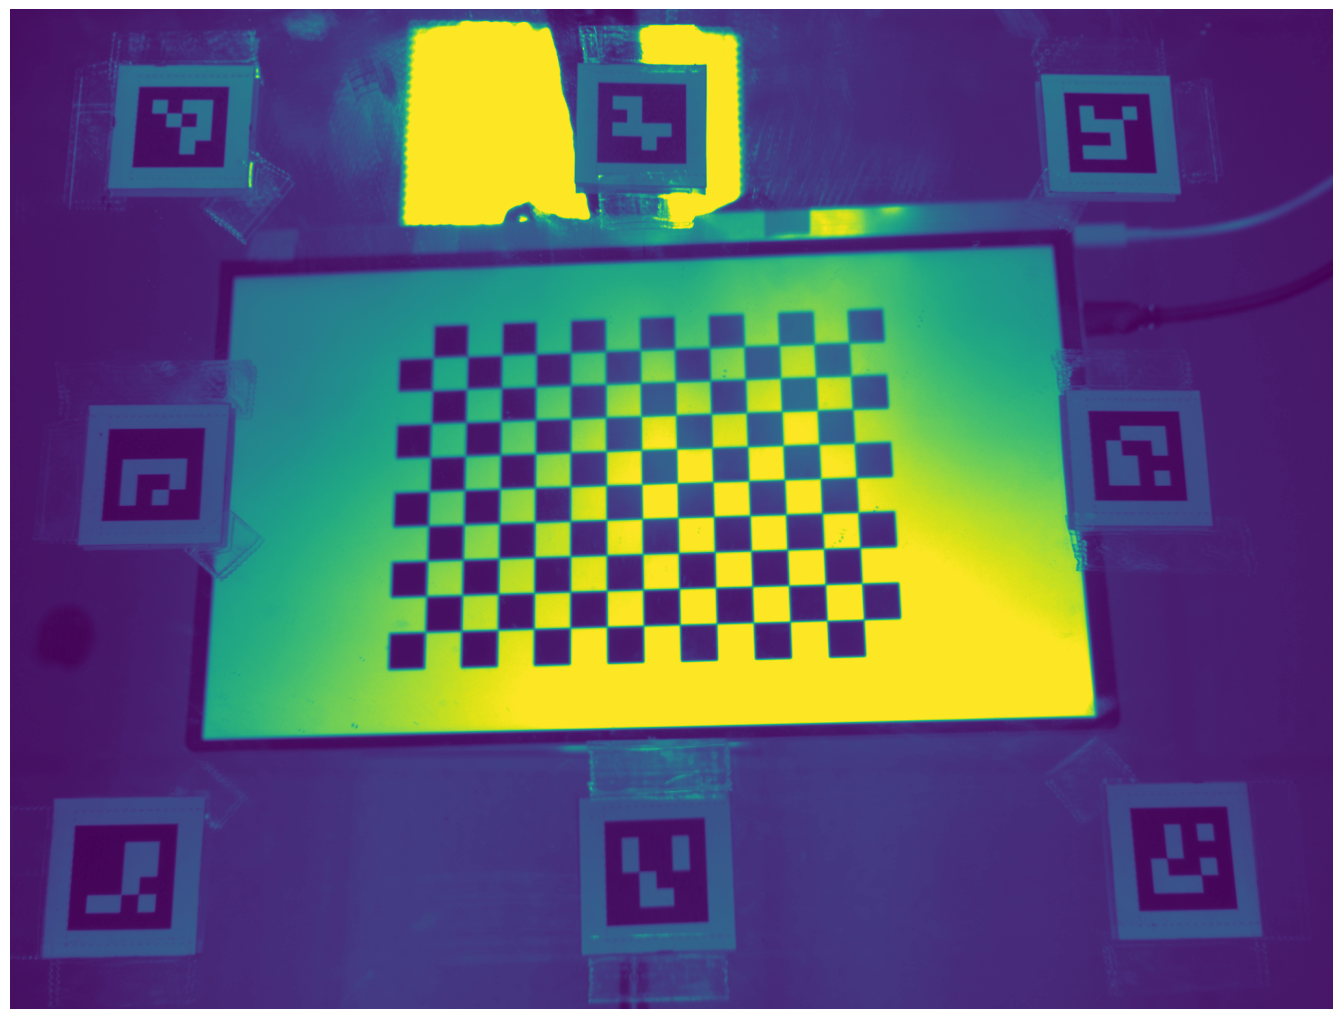

(1464, 1936)


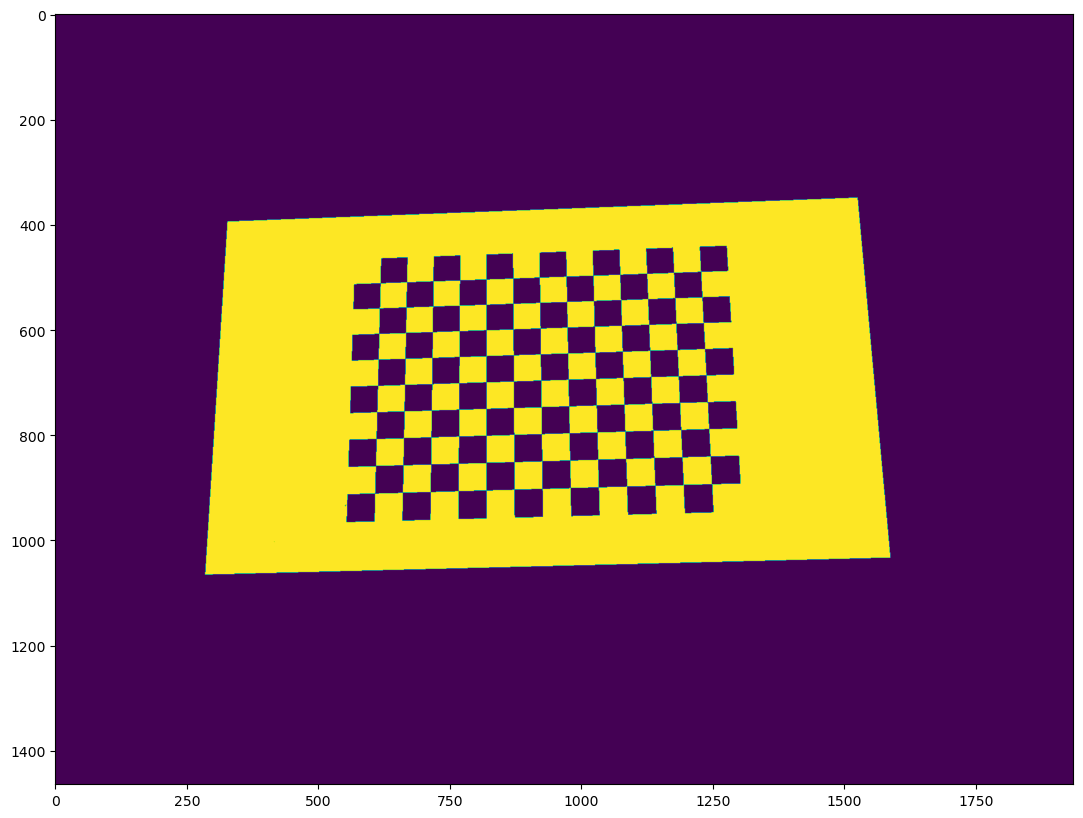

<Figure size 1500x1000 with 0 Axes>

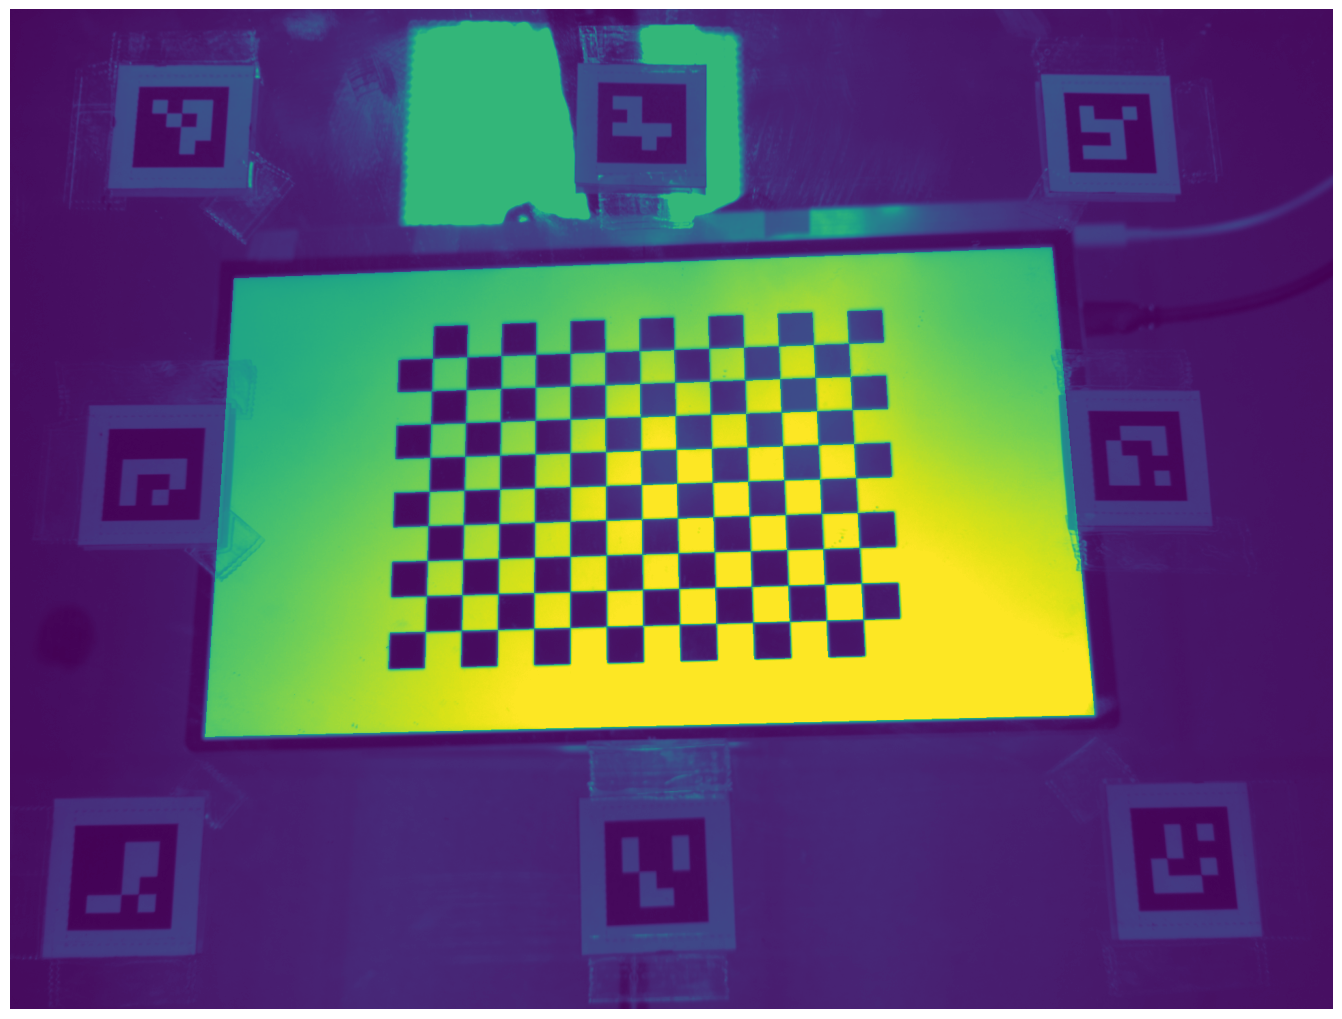

In [4]:
# geometric calibration validation (original, reprojected, comparison)
geo_calib_validation(geoCalibImgUndistortFile, displayintersect, displayScaleFactor)